# <div align="center">Компьютер говорит "НЕТ"</div>

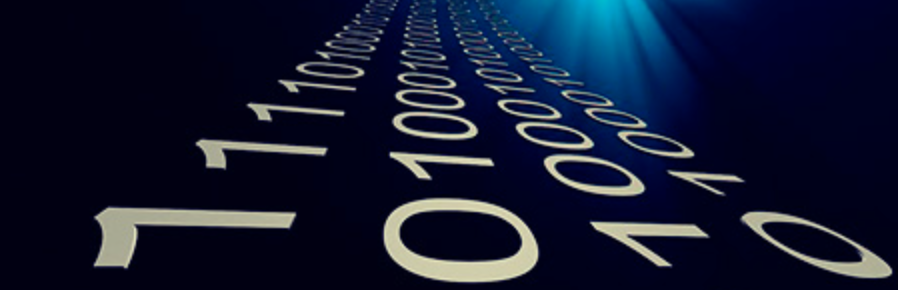

## 1. Импорт библиотек

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
from pandas import Series

import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from math import log as log
import os
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix, plot_confusion_matrix

pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings("ignore")

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
PATH_to_file = '/kaggle/input/sf-dst-scoring/'

/kaggle/input/mortality/mortality.xlsx
/kaggle/input/crimeage/table-20.csv
/kaggle/input/mortality2/mortality.csv
/kaggle/input/crimeage-fixed/table-20.csv
/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


## 2. Создание функций пользователя и их описание

- **show_roc_curve** - отображает ROC-кривую;
- **show_plot_boxplot** - строит гистограмму по столбцу и boxplot, показывает на нем среднее;



In [2]:
def show_roc_curve(y_true, y_pred_prob):
    """Функция отображает ROC-кривую"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot([0, 1], label='Случайный классификатор', linestyle='--')
    plt.plot(fpr, tpr, label='Логистическая регрессия')
    plt.title('Логистическая регрессия ROC AUC = %0.6f' %
              roc_auc_score(y_true, y_pred_prob))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

In [3]:
def show_plot_boxplot(df, col_name, bins=10):
    """Построение гистограммы по столбцу и boxplot-а"""
    color_text = plt.get_cmap('PuBu')(0.95)
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = (10, 5)
    _, axes = plt.subplots(2, 1)
    axes[0].hist(df, bins=bins)
    axes[0].set_title("Гистограмма и boxplot для признака '" + col_name + "'",
                      color=color_text,
                      fontsize=14)
    axes[1].boxplot(df, vert=False, showmeans=True)
    axes[1].set_title('')
    return

## 3. Фиксируем seed

In [4]:
RANDOM_SEED = 42

## 4. Загрузка данных

**train.csv** - данные для обучения модели;
**test.csv** - данные для тестирования модели; **mortality.csv** - внешние данные о вероятности смерти в зависимости от возраста; **table-20.csv** - зивисимость преступности от возраста


Описания полей

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

In [5]:
df_train = pd.read_csv(PATH_to_file + 'train.csv')
df_test = pd.read_csv(PATH_to_file + 'test.csv')

In [6]:
mort = pd.read_csv('/kaggle/input/mortality2/mortality.csv', sep=';')
crime = pd.read_csv('/kaggle/input/crimeage-fixed/table-20.csv', sep=';')
motral = mort[['Age', 'qx']].to_dict()['qx']
crime = crime.set_index('Age')['Per'].to_dict()

In [7]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['Train'] = 1  # помечаем где у нас трейн
df_test['Train'] = 0  # помечаем где у нас тест

#data = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем
df = df_train.append(df_test, sort=False).reset_index(drop=True)

## 5. Предварительный анализ данных

In [8]:
# Смотрим описательные характеристики тренировочного датасета
print(df_train.info())
display(df_train.describe().T)
display(df_train.describe(include='object').T)
display(df_train.isna().sum(0))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

,count,mean,std,min,25%,50%,75%,max
client_id,73799.0,55137.965094,31841.921168,1.000000,27440.500000,55274.000000,82758.500000,110147.000000
age,73799.0,39.280641,11.520378,21.000000,30.000000,37.000000,48.000000,72.000000
decline_app_cnt,73799.0,0.275749,0.804272,0.000000,0.000000,0.000000,0.000000,33.000000
good_work,73799.0,0.164894,0.371087,0.000000,0.000000,0.000000,0.000000,1.000000
score_bki,73799.0,-1.904724,0.498231,-3.624586,-2.259534,-1.920823,-1.569831,0.199773
bki_request_cnt,73799.0,2.000339,2.252073,0.000000,0.000000,1.000000,3.000000,53.000000
region_rating,73799.0,56.725701,13.055717,20.000000,50.000000,50.000000,60.000000,80.000000
home_address,73799.0,1.575509,0.527631,1.000000,1.000000,2.000000,2.000000,3.000000
work_address,73799.0,2.496280,0.689818,1.000000,2.000000,3.000000,3.000000,3.000000
income,73799.0,41099.775417,46166.322400,1000.000000,20000.000000,30000.000000,48000.000000,1000000.000000


,count,unique,top,freq
app_date,73799,120,18MAR2014,1018
education,73492,5,SCH,38860
sex,73799,2,F,41562
car,73799,2,N,49832
car_type,73799,2,N,59791
foreign_passport,73799,2,N,62733


client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
Train                 0
dtype: int64

In [9]:
# Смотрим описательные характеристики тестового датасета
print(df_test.info())
display(df_test.describe().T)
display(df_test.describe(include='object').T)
display(df_test.isna().sum(0))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

,count,mean,std,min,25%,50%,75%,max
client_id,36349.0,54945.647473,31706.052195,4.000000,27744.000000,54657.000000,82322.000000,110148.00000
age,36349.0,39.186002,11.513258,21.000000,30.000000,37.000000,48.000000,71.00000
decline_app_cnt,36349.0,0.268040,0.788478,0.000000,0.000000,0.000000,0.000000,30.00000
good_work,36349.0,0.166772,0.372777,0.000000,0.000000,0.000000,0.000000,1.00000
score_bki,36349.0,-1.904152,0.501764,-3.574197,-2.261909,-1.920823,-1.563957,0.18882
bki_request_cnt,36349.0,2.014471,2.296789,0.000000,0.000000,1.000000,3.000000,47.00000
region_rating,36349.0,56.802938,13.086646,20.000000,50.000000,50.000000,60.000000,80.00000
home_address,36349.0,1.573798,0.527428,1.000000,1.000000,2.000000,2.000000,3.00000
work_address,36349.0,2.501087,0.683227,1.000000,2.000000,3.000000,3.000000,3.00000
income,36349.0,40835.755729,43802.180951,1000.000000,20000.000000,30000.000000,48000.000000,1000000.00000


,count,unique,top,freq
app_date,36349,120,18MAR2014,473
education,36178,5,SCH,19138
sex,36349,2,F,20274
car,36349,2,N,24458
car_type,36349,2,N,29349
foreign_passport,36349,2,N,30988


client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
Train                 0
dtype: int64

### Выводы: 

в тренировочном наборе 73799 записей о кредитной истории, в тестовой - 36349. Всего 19 переменных (18 признаков + целевая):

- app_date - временная переменная;
- sex, car, car_type, good_work, foreign_passport - бинарные переменные;
- education, region_rating, home_address, work_address, sna, first_time - категориальные переменные;
- age, decline_app_cnt, score_bki, bki_request_cnt, income - числовые переменные;
- default - целевая переменная, индикатор дефолта.

Всего пропусков: 307+171 (307 - в наборе train, 171 - в наборе test), все пропуски в переменной education. Столбец client_id содержит числовой признак клиента, который не несет полезной для модели информации. В бинарном признаке default - целевая переменная, индикатор дефолта по кредиту (0 - не обнаружен, 1 - дефлот обнаружен).

Данные находятся в разном масштабе, будем применять скалирование

0    0.873006
1    0.126994
Name: default, dtype: float64


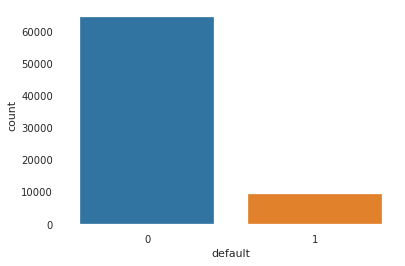

In [10]:
print(df_train['default'].value_counts(normalize=True))
sns.countplot(df_train['default'])

### Вывод - классы очень несбалансированы. На это нужно обратить внимание при обучении модели, иначе есть риск переобучиться на самый популярный класс.

## 6. Feature Engineering

### 6.1 Добавление внешних признаков, сортировка

Cперва займёмся преобразованием признаков -- категориальные/бинарные закодируем, а числовые приведем к одному масштабу.

In [11]:
# region_rating, first_time и sna решили использовать как категориальные и как числовые одновременно
df['region_rating_to_dummies'] = df.region_rating
df['first_time_to_dummies'] = df.first_time
df['sna_to_dummies'] = df.sna

In [12]:
# Дополним датасет дополнительными данными о смертности и уровне приступности в зависисти от возраста
df['mortality'] = df.age.map(motral)
df['mortality'] = df['mortality'].str.replace(',', '.')
df['mortality'] = df['mortality'].astype('float')

df['crime'] = df.age.map(crime)
df['crime'] = df['crime'].str.replace(',', '.')
df['crime'] = df['crime'].astype('float')

In [13]:
df_train.client_id.value_counts() # -- все id уникальны, можно будет просто отбрость эту колонку

2049      1
85187     1
85507     1
83458     1
87552     1
         ..
101156    1
107297    1
109344    1
21279     1
6141      1
Name: client_id, Length: 73799, dtype: int64

In [14]:
# внесем данные из резюме в списки
# временной ряд (1)
time_cols = ['app_date']
# бинарные переменные (default не включаем в список) (5+1 = 6)
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные переменные (Train не включаем в список, так как мы сами его добавили) (3+1=4)
cat_cols = [
    'education', 'region_rating_to_dummies', 'home_address', 'work_address',
    'sna_to_dummies', 'first_time_to_dummies'
]
# числовые переменные, client_id исключили из списка (8)
num_cols = [
    'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income', 'crime'
]
num_cols_ana = [
    'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income',
    'crime', 'mortality'
]
# client_id не включаем в списки

### 6.2 Обработка пропусков

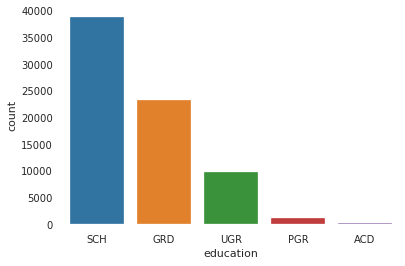

In [15]:
sns.countplot(df_train['education'])

In [16]:
df_train['education'].value_counts(dropna=False)

SCH    38860
GRD    23365
UGR     9816
PGR     1257
NaN      307
ACD      194
Name: education, dtype: int64

In [17]:
df_train.groupby(by=['education']).default.sum()

education
ACD       8
GRD    2105
PGR      81
SCH    5852
UGR    1291
Name: default, dtype: int64

In [18]:
# Просто заполняем самым популярным значенем:

df.education = df.education.fillna('SCH')

### 6.3 Преобразование временной переменной

Эта колонка - дата подачи заявления. Давайте приведём её в приемлимый формат дат.

In [19]:
df_train.app_date = pd.to_datetime(df_train.app_date)
df_test.app_date = pd.to_datetime(df_test.app_date)

In [20]:
## Посмотрим на распределение подач заявлений по дням недели:
df_train.app_date.dt.day_name().value_counts()

Tuesday      12176
Monday       12024
Wednesday    11740
Thursday     11615
Friday       11263
Saturday      8231
Sunday        6750
Name: app_date, dtype: int64

In [21]:
df_test.app_date.dt.day_name().value_counts()

Tuesday      6004
Wednesday    5841
Monday       5834
Thursday     5806
Friday       5486
Saturday     3971
Sunday       3407
Name: app_date, dtype: int64

In [22]:
# Давайте посмотрим на распределение дефолтов по дням недели.
# Это поможет понять, нужно ли использовать день недели как признак.
df_train.groupby(df_train.app_date.dt.day_name())['default'].mean()
# всё довольно равномерно

app_date
Friday       0.119950
Monday       0.127079
Saturday     0.130968
Sunday       0.129185
Thursday     0.131985
Tuesday      0.127382
Wednesday    0.124276
Name: default, dtype: float64

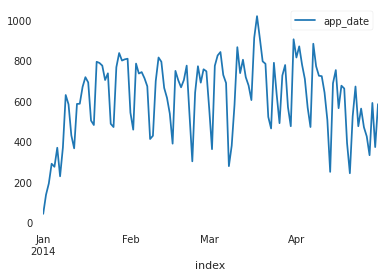

In [23]:
# Частота подачи заявки в конкретный день:

df_train.app_date.value_counts().to_frame().reset_index().sort_values(
    by=['index']).plot.line(x='index', y='app_date')

<AxesSubplot:xlabel='app_date'>

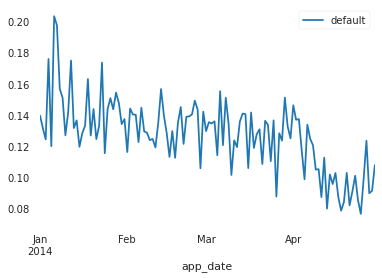

In [24]:
# Доля дефолтов в конкретный из дней:

df_train.groupby(
    df_train.app_date)['default'].mean().to_frame().reset_index().sort_values(
        by=['app_date']).plot.line(x='app_date', y='default')

Заметна зависимость времени от целевой переменной. Используя это наблюдение, создадим новые признаки

In [25]:
# Преобразуем формат признака
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')

In [26]:
# Выясняем начало и конец периода нашего датасета - это 1 января и 30 апреля 2014 года
start = df.app_date.min()
end = df.app_date.max()
start, end

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

In [27]:
# Вводим новый признак - номер дня с 1 января
df['days'] = (df.app_date - start).dt.days.astype('int')

#Номер месяца (можно попробовать удалить)
df['month'] = df['app_date'].dt.month

# количество заявок в данном дне
dates = df.app_date.value_counts()
df['app_cnt'] = df.app_date.apply(lambda x: dates[x])

### 6.4 Оценка корреляций¶

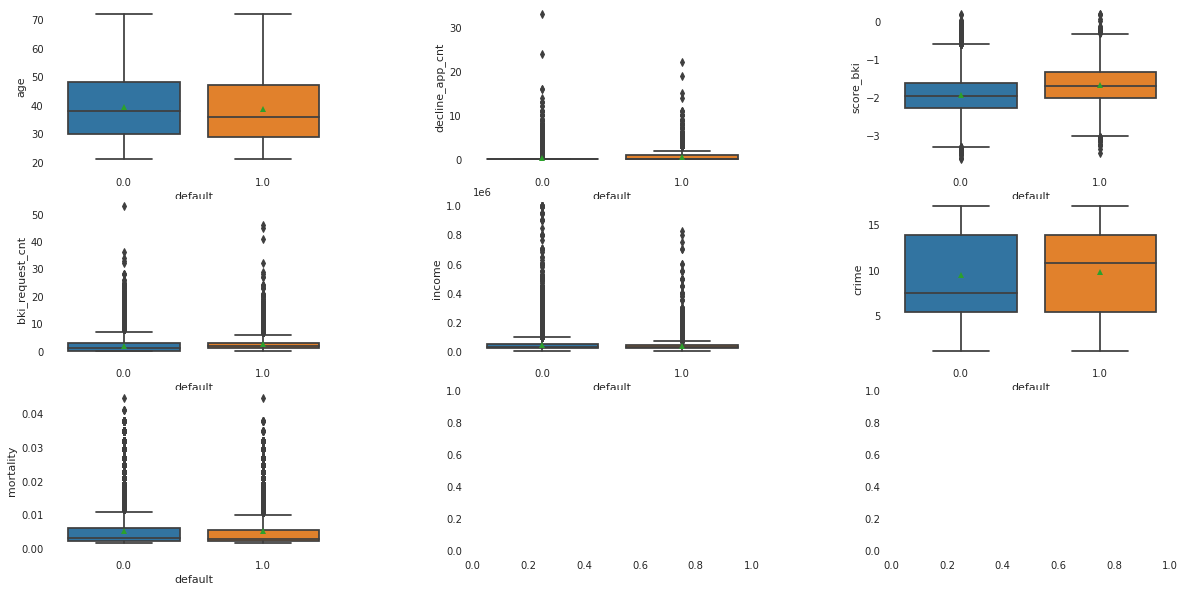

In [28]:
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
for i in range(len(num_cols_ana)):
    sns.boxplot(x="default",
                y=num_cols_ana[i],
                data=df,
                orient='v',
                ax=axes[i],
                showfliers=True,
                showmeans=True)

Выводы (анализ boxplot-ов) для числовых переменных:

- age: дефолтные клиенты в среднем младше
- decline_app_cnt: дефолтные клиенты в среднем имеют большее количество отмененных заявок
- score_bki: дефолтные клиенты в среднем имеют больший скоринговый балл по данным из БКИ
- bki_request_cnt: дефолтные клиенты в среднем имеют больше запросов в БКИ
- income: дефолтные клиенты в среднем имеют более низкий доход
- delta_deys: дефолтные клиенты в среднем имеют больше проблем с законом
- mortality: дефолтные клиенты в среднем имеют более низкие значения mortality

### 6.5 Анализ переменных

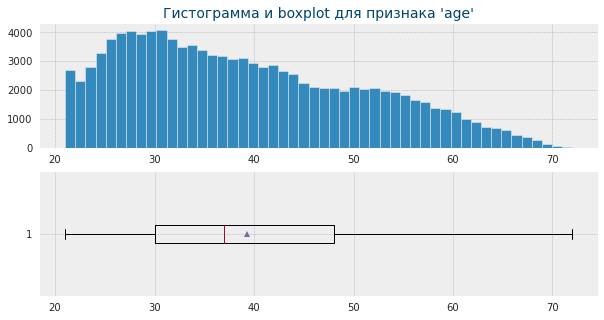

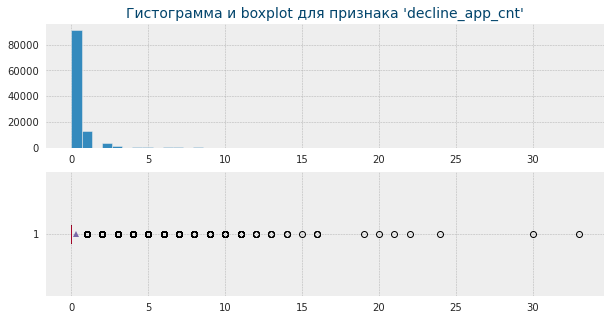

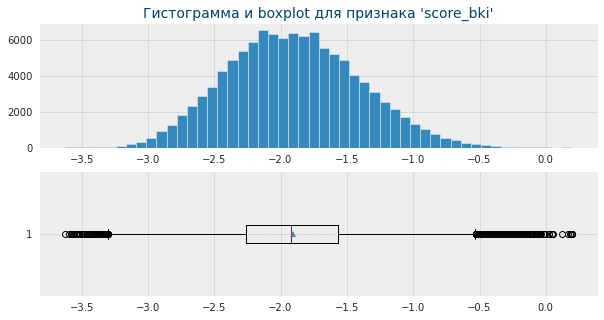

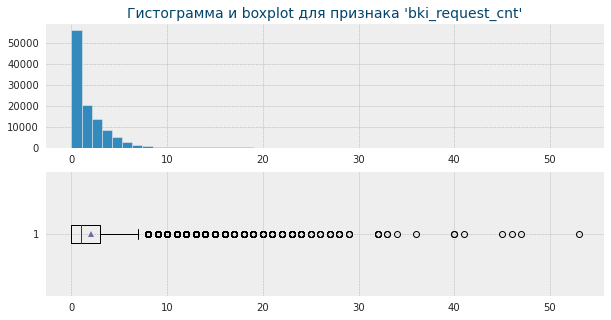

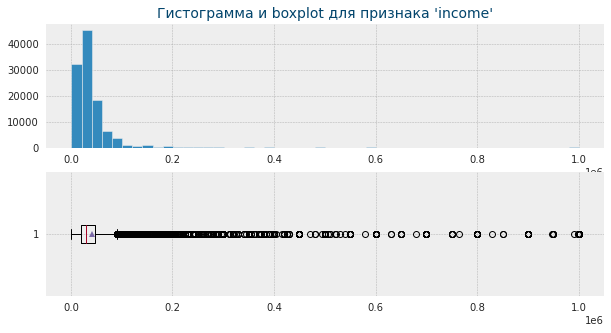

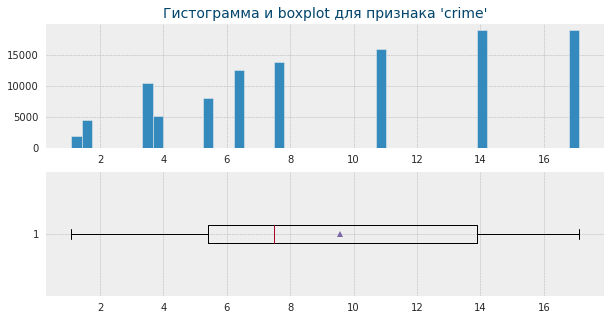

In [29]:
# Посмотрим на распределение и boxplot’ы для численных переменных.
for col in num_cols:
    show_plot_boxplot(df[col], col, bins=50)

### 6.6 Log-преобразование

После построения гистограмм стало очевидно, что распределения числовых переменных 'age', 'decline_app_cnt', 'bki_request_cnt', 'income' имеют тяжёлый правый хвост, кроме того, почти все числовые признаки (кроме 'age') содержат выбросы, к которым чувствительна LogisticRegression.

Для того чтобы сделать распределение данных переменных более нормальным, можно работать с логарифмированными величинами этих переменных. Тогда можно избежать чувствительности к сильным отклонениям в суммах у линейных моделей.
Анализ распределений и boxplot-ов показывает, что признак 'score_bki' может быть как положительным, так и отрицательным, его логарифмировать напрямую нельзя, но его распределение и так похоже на нормальное. Возьмем логарифм от числовых признаков 'age', 'decline_app_cnt', 'bki_request_cnt', 'income' и построим графики распределения логарифмированных переменных, потом оценим выбросы.

In [30]:
for column in num_cols:
    if column != 'score_bki':
        df[column] = np.log(df[column] + 1)

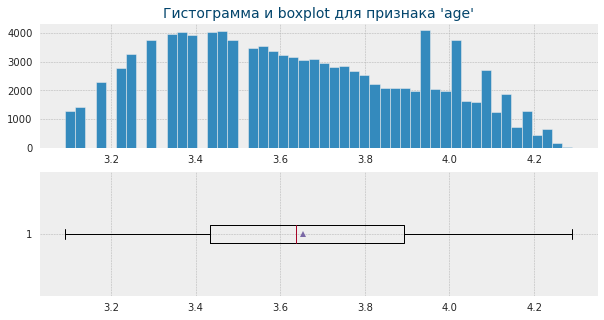

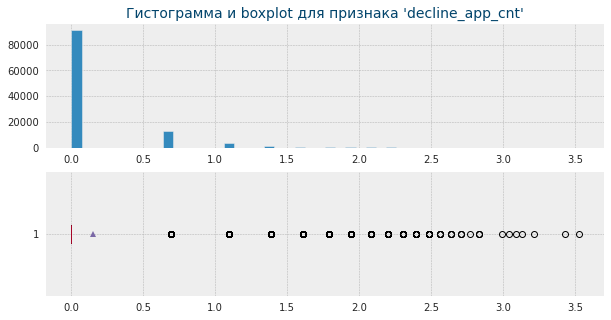

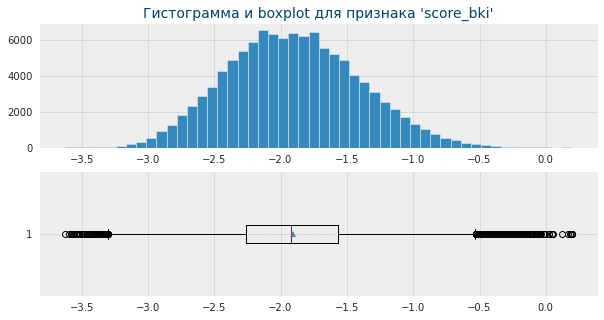

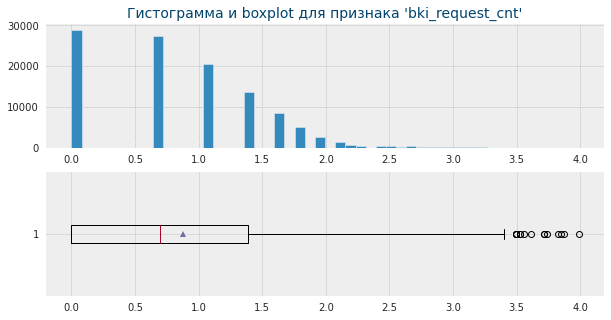

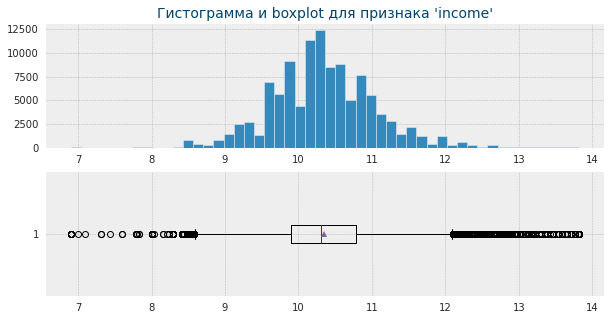

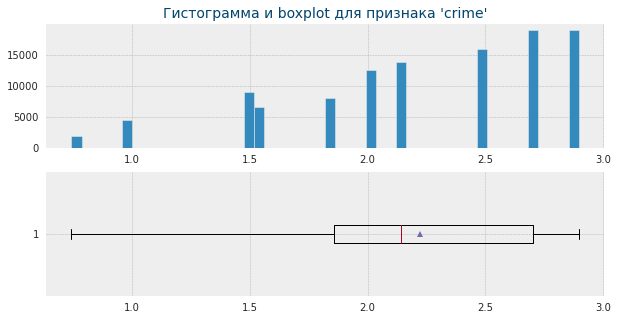

In [31]:
# Посмотрим на распределение и boxplot’ы для численных переменных после логарифмирования
for col in num_cols:
    show_plot_boxplot(df[col], col, bins=50)

После логарифмирования некоторые переменные стали менее смещёнными. Такой принцип можно применить перед построением модели.

Выбросов стало заметно меньше.

### 6.7 Преобразование бинарных переменных

Убедимся в том, что в бинарных переменных ('sex', 'car', 'car_type', 'good_work', 'foreign_passport') записано всего два значения

In [32]:
for col in bin_cols:
    print(f'Уникальные записи в столбце {col}:')
    print(df[col].value_counts())

Уникальные записи в столбце sex:
F    61836
M    48312
Name: sex, dtype: int64
Уникальные записи в столбце car:
N    74290
Y    35858
Name: car, dtype: int64
Уникальные записи в столбце car_type:
N    89140
Y    21008
Name: car_type, dtype: int64
Уникальные записи в столбце good_work:
0    91917
1    18231
Name: good_work, dtype: int64
Уникальные записи в столбце foreign_passport:
N    93721
Y    16427
Name: foreign_passport, dtype: int64


Преобразуем бинарные переменные при помощи класса LabelEncoder. Исходя из описания, наши признаки строго бинарные (принимают только два значения) и сюрпризов (новых неизвестных значений) быть не должно.

In [33]:
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

# Убедимся в преобразовании
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,default,Train,region_rating_to_dummies,first_time_to_dummies,sna_to_dummies,mortality,crime,days,month,app_cnt
0,25905,2014-02-01,SCH,1,4.143135,1,1,0.000000,0,-2.008753,...,0.0,1,50,1,4,0.01916,0.993252,31,2,794
1,63161,2014-03-12,SCH,0,4.094345,0,0,0.000000,0,-1.532276,...,0.0,1,50,1,4,0.01496,1.504077,70,3,1110
2,25887,2014-02-01,SCH,1,3.258097,1,0,1.098612,0,-1.408142,...,0.0,1,80,4,1,0.00187,2.895912,31,2,794
3,16222,2014-01-23,SCH,0,3.988984,0,0,0.000000,0,-2.057471,...,0.0,1,50,3,1,0.00902,1.856298,22,1,1060
4,101655,2014-04-18,GRD,1,3.891820,0,0,0.000000,1,-1.244723,...,0.0,1,60,4,1,0.00599,2.014903,107,4,981


### 6.8 Преобразование категориальных переменных

Для преобразования будем использовать one-hot encoding

In [34]:
df = pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)

# Убедимся в преоброзовании
df.head()

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address_2,work_address_3,sna_to_dummies_1,sna_to_dummies_2,sna_to_dummies_3,sna_to_dummies_4,first_time_to_dummies_1,first_time_to_dummies_2,first_time_to_dummies_3,first_time_to_dummies_4
0,25905,2014-02-01,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,...,1,0,0,0,0,1,1,0,0,0
1,63161,2014-03-12,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,...,0,1,0,0,0,1,1,0,0,0
2,25887,2014-02-01,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,...,1,0,1,0,0,0,0,0,0,1
3,16222,2014-01-23,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,...,0,1,1,0,0,0,0,0,1,0
4,101655,2014-04-18,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,...,0,1,1,0,0,0,0,0,0,1


### 6.8 Создаем новые признаки 

In [35]:
df['decline_flag'] = df.decline_app_cnt.apply(lambda x: 0 if x < 1 else 1)
df['decline_flag'].value_counts()

0    103971
1      6177
Name: decline_flag, dtype: int64

In [36]:
# # Сгенерируем новые признаки комбинируя категорийные и числовые признаки
df['new'] = ((df.income**2) * df.region_rating) / df.age
df['new2'] = (df.score_bki * df.region_rating) / df.age
df['new4'] = (df.age / df.first_time) * df.score_bki
df['new5'] = (df.score_bki * df.sna)
df['new6'] = (df.income**2) * df.sna
df['new7'] = ((df.income**2) * df.first_time) / df.age

In [37]:
df['incomeˆ2'] = df['income']**2
df['incomeˆ4'] = df['income']**4
df['incomeˆlog'] = np.log(df['income'] + 1)
df['incomeˆsqrt'] = np.sqrt(df['income'])

In [38]:
df['decline_app_cntˆ2'] = df['decline_app_cnt']**2
df['decline_app_cntˆ4'] = df['decline_app_cnt']**4
df['decline_app_cntˆlog'] = np.log(df['decline_app_cnt'] + 1)
df['decline_app_cntˆlog'] = np.sqrt(df['decline_app_cnt'])

In [39]:
df['bki_request_cntˆ2'] = df['bki_request_cnt']**2
df['bki_request_cntˆ4'] = df['bki_request_cnt']**4
df['bki_request_cntˆlog'] = np.log(df['bki_request_cnt'] + 1)

df['region_ratingˆ2'] = df['region_rating']**2
df['region_ratingˆ4'] = df['region_rating']**4
df['region_ratingˆlog'] = np.log(df['region_rating'] + 1)
df['region_ratingˆlog'] = np.sqrt(df['region_rating'])
df['region_ratingˆexp'] = np.exp(df['region_rating'])

In [40]:
df['score_bkiˆ2'] = df['score_bki']**2
df['score_bkiˆ4'] = df['score_bki']**4
df['score_bkiˆsqrt'] = np.sqrt(abs(df['score_bki']))
df['score_bkiˆlog'] = np.log(abs(df['score_bki']))
df['score_bkiˆexp'] = np.exp(abs(df['score_bki']))

In [41]:
num_cols_2 = ['age', 'crime', 'mortality', 'new', 'new7']
for i in num_cols_2:
    df[i + 'ˆ2'] = df[i]**2
    df[i + 'ˆ4'] = df[i]**4
    df[i + 'ˆ6'] = df[i]**6
    df[i + '_log'] = np.log(abs(df[i]))
    df[i + '_sqrt'] = np.sqrt(df[i])

In [42]:
df['new2ˆ2'] = df['new2']**2
df['new2ˆ3'] = df['new2']**3
df['new2ˆ4'] = df['new2']**4
df['new2ˆlog'] = np.log(abs(df['new2']))

In [43]:
df['new6ˆ2'] = df['new6']**2
df['new6ˆ4'] = df['new6']**4
df['new6ˆsqrt'] = np.sqrt(abs(df['new6']))
df['new6ˆlog'] = np.log(abs(df['new6']))

In [44]:
df['daysˆ2'] = df['days']**2

### 6.9 Удаляем малозначительные и признаки на основе которых были созданы новые

In [45]:
df = df.drop([
    'app_date', 'client_id', 'decline_app_cnt', 'car', 'days', 'new', 'new7',
    'new2', 'new6', 'region_rating', 'first_time', 'sna', 'education_PGR',
    'crime', 'mortality', 'bki_request_cnt', 'income'
],
             axis=1)

### 6.10 Проверяем признаки с помощью матрицы корреляций

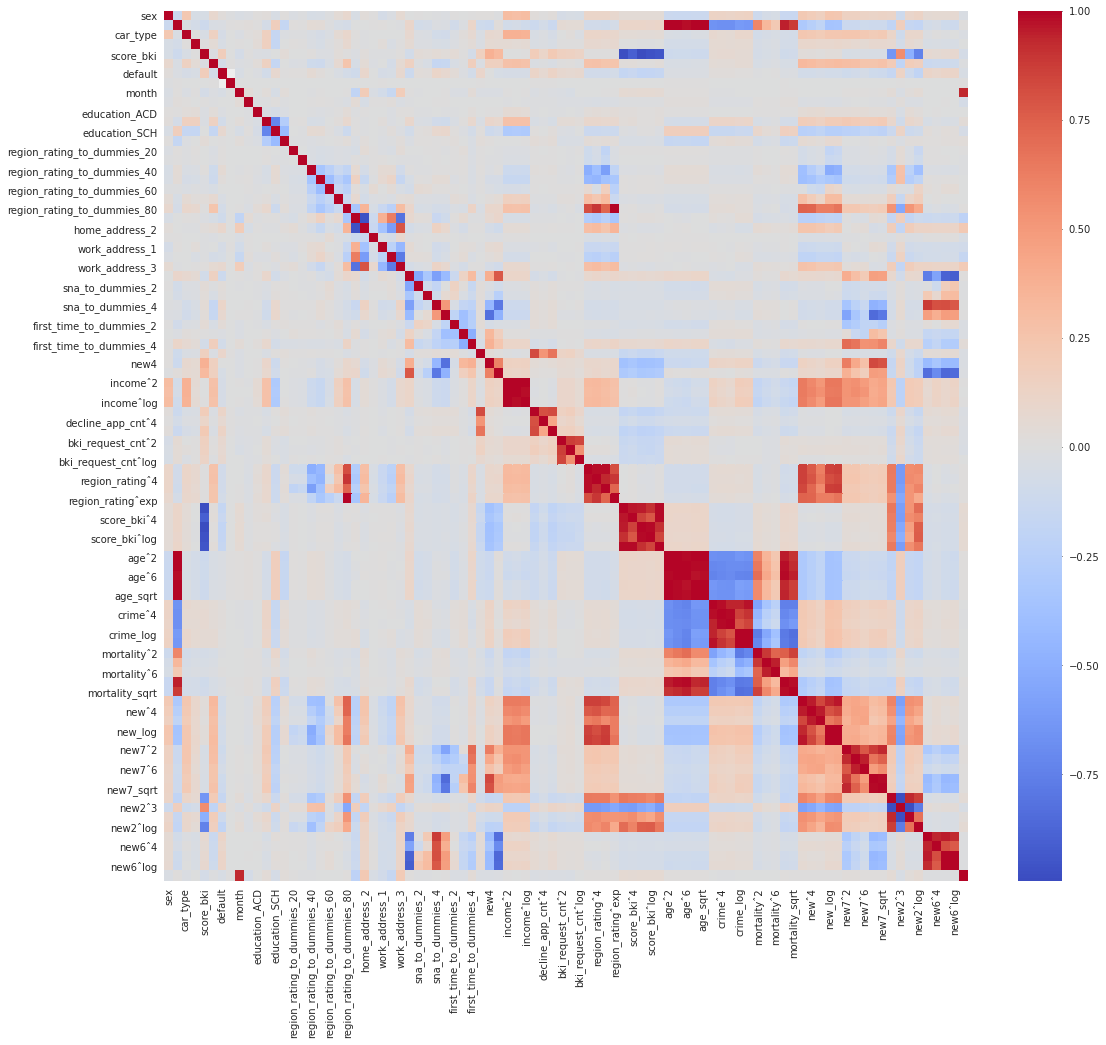

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(18, 16))
ax = sns.heatmap(df.corr(), cmap='coolwarm')

## 7. Подготовка данных к машинному обучению

### 7.1 Разбиение данных

In [47]:
train_data = df.query('Train == 1').drop(['Train'], axis=1)
test_data = df.query('Train == 0').drop(['Train'], axis=1)

y = train_data.default.values  # наш таргет
X = train_data.drop(['default'], axis=1)

In [48]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

### 6.2. Стандартизация (StandardScaler)
Стандартизацию проводим отдельно для трейна и теста

In [49]:
scaler = MinMaxScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [50]:
test_data.shape, train_data.shape, X_train.shape, X_test.shape, y_train.shape

((36349, 89), (73799, 89), (59039, 88), (14760, 88), (59039,))

### 6.2 Первая модель

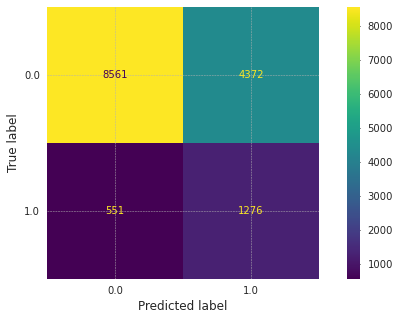

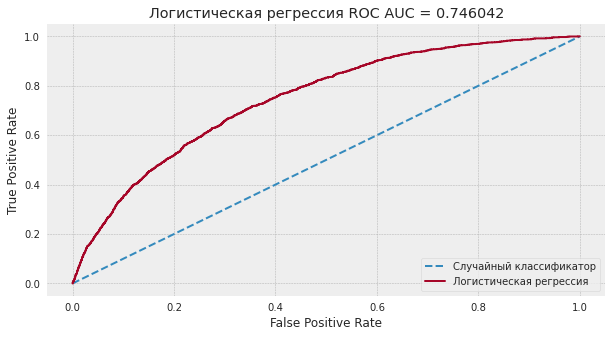

In [51]:
parameters = {'C': list(np.linspace(0, 1, num=10))}
model = LogisticRegression(class_weight="balanced",
                           max_iter=800,
                           solver='sag',
                           random_state=RANDOM_SEED)
grid_search_cv_fr = GridSearchCV(model, parameters, n_jobs=-1)
grid_search_cv_fr.fit(X_train_scaler, y_train)

bestgrid_search_cv_fr = grid_search_cv_fr.best_params_
best_rf = grid_search_cv_fr.best_estimator_
best_rf.fit(X_train_scaler, y_train)

probs = best_rf.predict_proba(X_test_scaler)

y_pred_prob = probs[:, 1]
y_pred = best_rf.predict(X_test)

plot_confusion_matrix(best_rf, X_test_scaler, y_test)

# Оценка качества модели
show_roc_curve(y_test, y_pred_prob)

## 6.3 Вторая модель

In [52]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
parameters = {
    'n_estimators': range(1, 51, 10),
    'max_depth': range(1, 13, 2),
    'min_samples_leaf': range(1, 8),
    'min_samples_split': range(2, 10, 2),
}
grid_search_cv_fr = GridSearchCV(rf, parameters, cv=3, n_jobs=-1)
grid_search_cv_fr.fit(X_train_scaler, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 13, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(1, 51, 10)})

In [53]:
bestgrid_search_cv_fr = grid_search_cv_fr.best_params_
best_rff = grid_search_cv_fr.best_estimator_
best_rff.fit(X_train_scaler, y_train)

RandomForestClassifier(max_depth=9, min_samples_leaf=2, n_estimators=41,
                       n_jobs=-1, random_state=0)

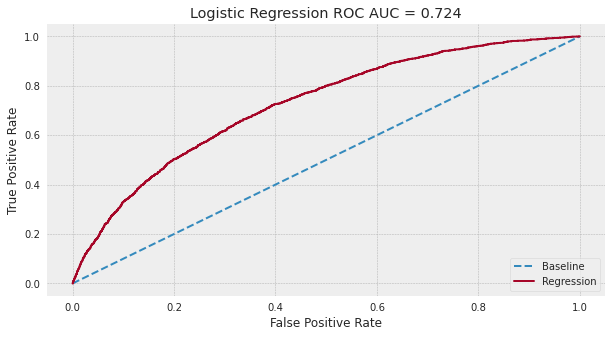

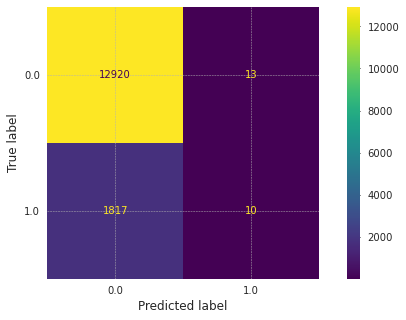

In [54]:
rand = RandomForestClassifier(max_depth=9,
                              min_samples_split=4,
                              n_estimators=21,
                              n_jobs=-1,
                              random_state=0)
rand.fit(X_train_scaler, y_train)
probs = rand.predict_proba(X_test_scaler)
probs = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()
rand.feature_importances_
plot_confusion_matrix(rand, X_test_scaler, y_test)

<AxesSubplot:>

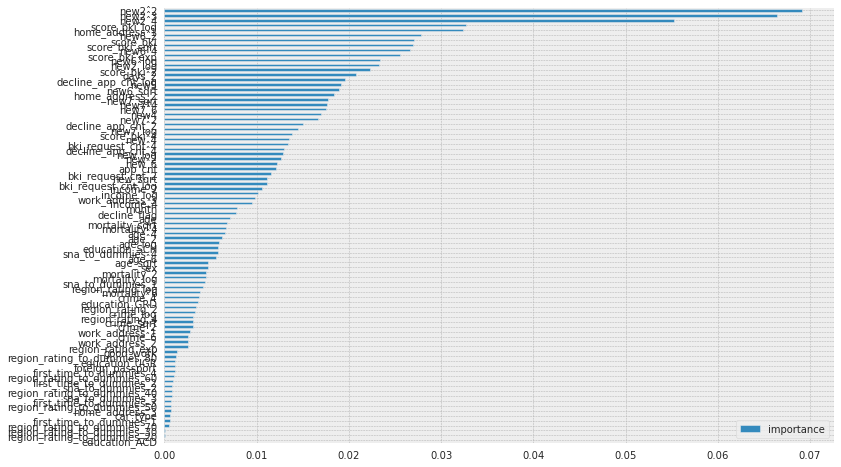

In [56]:
imp = pd.DataFrame(rand.feature_importances_,
                   index=X_train.columns,
                   columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))

In [57]:
imp = imp.sort_values(by='importance')
imp.head(10)

,importance
education_ACD,0.000000
region_rating_to_dummies_20,0.000068
region_rating_to_dummies_30,0.000071
region_rating_to_dummies_70,0.000442
first_time_to_dummies_1,0.000583
car_type,0.000620
home_address_3,0.000662
region_rating_to_dummies_50,0.000697
first_time_to_dummies_3,0.000739
sna_to_dummies_3,0.000812


## Submission

In [59]:
X_train = train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

In [60]:
test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 89), (73799, 89), (73799, 88), (73799,), (36349, 88))

In [61]:
scaler = MinMaxScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [62]:
best_rf.fit(X_train_scaler, y_train)

LogisticRegression(C=0.1111111111111111, class_weight='balanced', max_iter=800,
                   random_state=42, solver='sag')

In [63]:
y_pred_prob = best_rf.predict_proba(X_test_scaler)[:, 1]
# y_pred_prob = model.predict_proba(X_test)[:,1]

submit = pd.DataFrame(df_test.client_id)
submit['default'] = y_pred_prob
submit.to_csv('submission.csv', index=False)
submit.head(10)

,client_id,default
0,74835,0.202441
1,17527,0.756905
2,75683,0.311351
3,26883,0.384705
4,28862,0.122302
5,99881,0.529611
6,26630,0.775012
7,79934,0.194585
8,16605,0.145325
9,105449,0.115398
